In [88]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import plot_tree

In [76]:
train = pd.read_csv("./data/feature_selected/train_gearbox.csv", sep=",")
test = pd.read_csv("./data/feature_selected/test_gearbox.csv", sep=",")

In [77]:
reg_target_name = "RUL (Target)"
class_target_name = "Failure (Target)"
drop_cols = [reg_target_name, class_target_name, "Turbine_ID", "Timestamp", "Unnamed: 0", "index_y"]

X_train = train.drop(columns=drop_cols)
y_train = train[reg_target_name]
X_test = test.drop(columns=drop_cols)
y_test = test[reg_target_name]

In [78]:
X_train.head()

,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Prod_LatestAvg_ActPwrGen0,Blds_PitchAngle_Std,Grd_Prod_Freq_Avg,Min_Pressure,Min_Humidity,Max_Precipitation,Max_Raindetection
0,15.0,300.4,0,0.4,50.0,1009.0,51.0,0.0,0.0
1,-3.4,97.7,0,0.6,50.0,1008.0,53.0,0.0,0.0
2,6.2,30.8,-783,11.2,50.0,1007.0,28.0,0.0,0.0
3,-49.1,217.8,-1316,0.1,50.0,1012.0,56.0,0.0,0.0
4,-21.5,82.9,-300,0.0,50.0,1018.0,65.0,0.0,0.0


In [79]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [80]:
base_estimator = DecisionTreeRegressor(random_state=0)
param_grid = {
    "max_depth": [5, 10, 20],#scipy.stats.randint(5, 60),
    "min_samples_leaf": [1, 10, 50, 100],#scipy.stats.randint(1, 100),
}
sh = GridSearchCV(base_estimator, param_grid, scoring="neg_mean_squared_error").fit(X_train, y_train)
clf = sh.best_estimator_
report(sh.cv_results_)

Model with rank: 1
Mean validation score: -0.008 (std: 0.001)
Parameters: {'max_depth': 5, 'min_samples_leaf': 100}

Model with rank: 2
Mean validation score: -0.008 (std: 0.001)
Parameters: {'max_depth': 5, 'min_samples_leaf': 50}

Model with rank: 3
Mean validation score: -0.008 (std: 0.001)
Parameters: {'max_depth': 10, 'min_samples_leaf': 100}



In [81]:
@interact_manual
def understand_decisions(column=X_test.columns, datapoints=100):
    sample = X_test.sample()
    min = int(X_test[column].min())
    max = int(X_test[column].max())
    scaler = (max - min) / datapoints
    predictions = []
    for i in range(datapoints):
        sample[column] = i * scaler + min
        predictions.append(clf.predict(sample))
    plt.scatter(np.arange(min, max, scaler), predictions)
    

interactive(children=(Dropdown(description='column', options=('Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg…

<BarContainer object of 9 artists>

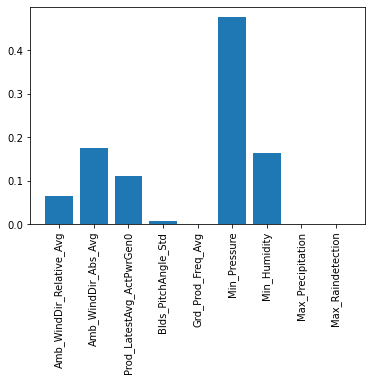

In [82]:
plt.xticks(rotation=90)
plt.bar(X_test.columns, clf.feature_importances_)

In [84]:
def plot_decision_tree(model, feature_names, class_names):
    # plot_tree function contains a list of all nodes and leaves of the Decision tree
    tree = plot_tree(model, feature_names = feature_names, class_names = class_names,
                     rounded = True, proportion = True, precision = 2, filled = True, fontsize=10)
    
    # I return the tree for the next part
    return tree

In [90]:
def plot_decision_path_tree(model, X, class_names=[]):
    fig = plt.figure(figsize=(10, 10))
    feature_names = X.index if type(X) == type(pd.Series()) else X.columns
    
    # Getting the tree from the function programmed above
    tree = plot_decision_tree(model, feature_names, class_names)
    
    # Get the decision path of the wanted prediction 
    decision_path = model.decision_path(X)

    # Now remember the tree object contains all nodes and leaves so the logic here
    # is to loop into the tree and change visible attribute for components that 
    # are not in the decision path
    for i in range(0,len(tree)):
        if i not in decision_path.indices:
            plt.setp(tree[i],visible=False)

    plt.show()

In [98]:
@interact_manual
def plot_tree_paths(column=X_test.columns, datapoint=(1, 100, 1)):
    sample = X_test.sample()
    min = int(X_test[column].min())
    max = int(X_test[column].max())
    new_value = min + (datapoint / 100) * (max - min)
    print("feature: {}, with value: {}".format(column, new_value))
    sample[column] = new_value
    plot_decision_path_tree(clf, sample, class_names=["RUL (Target)"])

interactive(children=(Dropdown(description='column', options=('Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg…